Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [2]:
NICKNAME = "nazar-si"

---

In [3]:
import numpy as np
from scipy.linalg import block_diag

Рассмотрим систему линейных уравнений, матрица правой части которой является "ленточной" и имеет следующую структуру: ненулевые элементы расположены на трех центральных диагонялях и на двух "крыльях". Матрицы такой структуры возникают, например, при решении задачи на нахождение электростатического потенциала $\phi(x, y)$, cоздаваемого двумерным распределением заряда $\rho(x, y)$ при дискретизации на сетке уравнения Пуассона

$$
\Delta \phi = -4\pi \rho\;.
$$
Мы будем решать эту задачу для простоты на квадрате с нулевым потенциалом на границе.
Простейшая сеточная аппроксимация - $\phi(x_i,y_j) = \phi_{ij}$ "схема крест"
$$
\frac{u_{i-1,j} - 2 u_{ij}+u_{i+1,j}}{h^2} + \frac{u_{i,j-1} - 2 u_{ij}+u_{i,j+1}}{h^2} = \rho_{ij}.
$$
(детали см. напр. А.А. Самарский, А.В. Гулин, Численные методы, ч. 3 гл. 1, параграф 1).

Заметим, что эти уравнения верны для внутренних узлов сетки, а поскольку внешние узлы сетки равны нулю, они войдут с нулевыми коэффициентами в уравнения на внутрении и можно о внешних узлах просто забыть.

Представим вектор решение в виде одномерного вектора по правилу $\phi_{i,j} = y_{j\cdot n+i}$, где $n$ - число внутренних узлов на строне квадрата.

Тогда всю систему уравнений можно представить в виде:
$$
\hat{m} \mathbf{y} = \mathbf{\tilde{f}}, 
$$
где матрица $m$ имеет блочную структуру, отвечающую вычисления производных по оси x (при неизменном j) и два крыла, отвечающие соседним по $y$ клеткам, то есть их индекс сдвинут ровно на $n$. 


Размер матрицы растет с уменьшением шага сетки $h$ как $O(1/h^2)$. Таким образом, приходится иметь дело с разреженными матрицами огромного размера.

Матрицу `m` создадим следующим образом:

In [10]:
def lhs_matrix(n):
    # Диагональный блок
    a = np.zeros((n, n))

    idx = np.arange(n)

    a[idx, idx] = -4 # u_{ij}
    a[idx[:-1], idx[:-1]+1] = 1 # соседи по x
    a[idx[1:], idx[1:]-1] = 1

    # собираем блочно-диагональную матрицу `m`
    m = block_diag(*(a,)*n)

    # заполняем "крылья" - соседи по y
    idx = np.arange(m.shape[0])

    m[idx[:-n], idx[:-n] + n] = 1
    m[idx[n:], idx[n:] - n] = 1
    return m

In [11]:
m = lhs_matrix(3)

with np.printoptions(linewidth=99):
    print(m)

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]


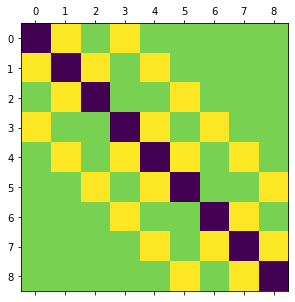

In [6]:
import matplotlib.pyplot as plt
plt.matshow(m)

Зададим вектор правой части системы $b$, символизирующий точечный заряд в центре: (для нечетного n)

In [7]:
b = np.zeros(m.shape[0])
b[m.shape[0]//2] = -1

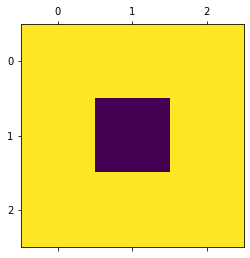

In [9]:
plt.matshow(b.reshape(3, 3))

Составьте функцию, вычисляющую решение системы уравнений $m x = b$ **методом Зейделя** с заданной точностью $\epsilon$.

Не пользуйтесь функциями `np.linalg.solve`, `np.linalg.inv` и т.п. Обратите внимание на функции `np.triu` и `scipy.linalg.solve_triangular`.

In [39]:
from scipy.linalg import solve_triangular

def seidel_solve(m, b, x0, eps=1e-5, maxiter=500):
   """ Solve `m @ x = b` with Seidel iteration.
   
   Parameters
   ----------
   m : ndarray, shape (n, n)
      Input matrix
   b : ndarray, shape (n,)
      Right-hand side
   x0 : ndarray, shape (n, )
      Initial point for the iteration
   eps : float, optional
      Target accuracy.
      Stop iterations when the 2-norm of 
      `|x_k - x_{k-1}| < eps`
   maxiter : int
      Maximum allowed number of iterations.
      
   Returns
   -------
   x : ndarray, shape (n,)
      The approximation to the solution of `m @ x = b`
   nit : the number of iterations performed.
   """

   x = x0
   # итерациями решаем:
   # Lx = b - Ux 
   L = np.triu(m)
   U = np.tril(m, -1)
   i = 0
   while True:
      i += 1
      px = np.copy(x)
      x = solve_triangular(L, b - U @ x)
      if np.linalg.norm(x - px) < eps or i >= maxiter:
         return x, i


In [40]:
m = lhs_matrix(n=6)
b = np.zeros(m.shape[0])
b[b.size//2] = 1

x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0)

from numpy.testing import assert_allclose
assert_allclose(x,
                np.linalg.solve(m, b), atol=2e-5)


Прокомментируйте зависимость числа итераций, требуемых для достижения заданной точности, от $\epsilon$, построив соовествующие график для какого-нибудь примера.

Зависимость числа итераций от ошибки убывает линейно в логарифмическом масштабе
ln(epsilon) = k-x
n ∝ exp(1 / epsilon)
В такой ситуации при уменьшении epsilon число итераций будет расти экспоненциально, то есть очень быстро и метод становится неэффективен


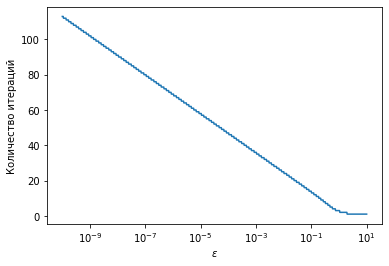

In [44]:
m = lhs_matrix(6)
b = np.zeros(m.shape[0])
x0 = np.ones(m.shape[0])

b[b.size//2] = 1
its = []
eps = np.logspace(1, -10, 1000)
for e in eps:
    its.append(seidel_solve(m, b, x0, eps=e)[1])

plt.plot(eps, its)
plt.xscale('log')
plt.xlabel("$\\varepsilon$")
plt.ylabel("Количество итераций")

print("Зависимость числа итераций от ошибки убывает линейно в логарифмическом масштабе")
print("ln(epsilon) = k-x")
print("n ∝ exp(1 / epsilon)")

print("В такой ситуации при уменьшении epsilon число итераций будет расти экспоненциально, то есть очень быстро и метод становится неэффективен")


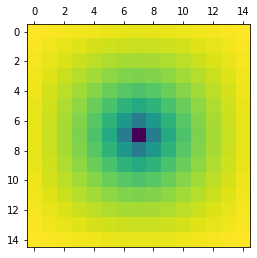

In [48]:
# Построим решение
m = lhs_matrix(n=15)
b = np.zeros(m.shape[0])
b[b.size//2] = 1


x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0, eps=1e-6, maxiter=1000)
x_res=x.reshape(15,15)
plt.matshow(x_res)

## если вы всё сделали правильно, ничего удивительного мы тут не увидим

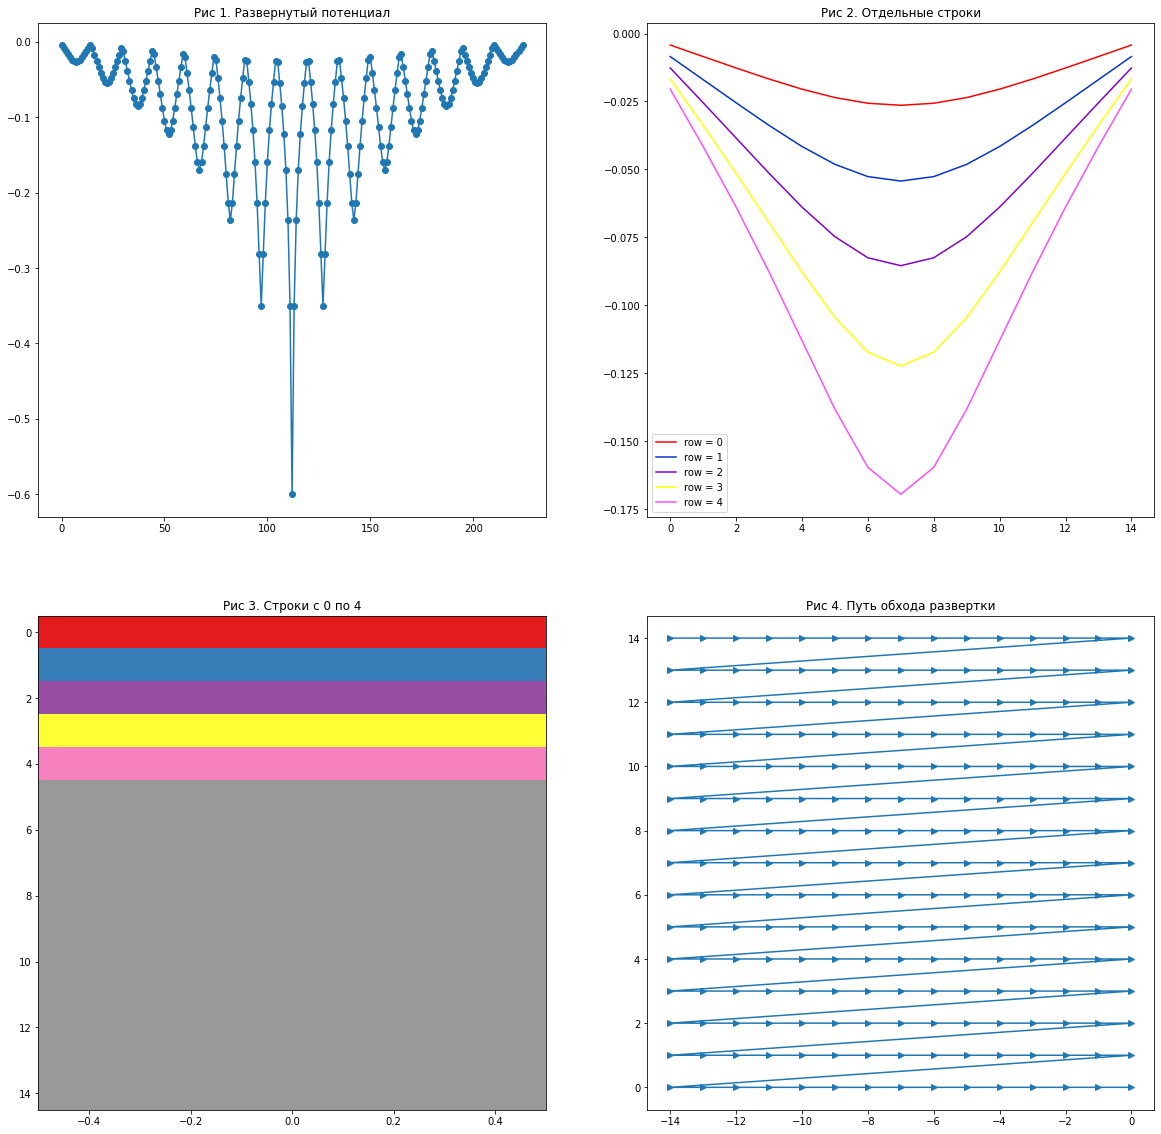

In [87]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
# Однако в нашем одномерном представлении зависимость менее тривиальна:
ax[0][0].plot(x, 'o-')
ax[0][0].set_title("Рис 1. Развернутый потенциал")
# Прокомментируйте характер зависимости значения от номера компоненты в ячейке ниже

colors = [(1, 0, 0), (0, 0.2, 0.8), (0.5, 0, 0.8), (1, 1, 0), (1, 0.3, 1)]
for i in range(5):
    ax[0][1].plot(x[15 * i :15 * (i + 1)], label=f"row = {i}", color=colors[i])
ax[0][1].set_title("Рис 2. Отдельные строки")
ax[1][0].set_title("Рис 3. Строки с 0 по 4")
ax[1][1].set_title("Рис 4. Путь обхода развертки")


ax[1][0].imshow(np.array([[0, 1, 2, 3, 4] + [5] * 10]).T, aspect="auto", cmap="Set1")
plt.plot(- (np.arange(0, 15 ** 2) % 15),np.arange(0, 15 ** 2) // 15, "->")
ax[0][1].legend()


Выше я также построил график различных значений $x$ разнесенных на ширину сетки. 

Два графика наверху: 
Как мы видим, каждый из уходящих вниз пиков (рис 2) представляет из себя отдельные пики из рисунка 1. Выписывая значения массива в один ряд, мы переходим к представлению, где данные значения чередуются. Наши начальные условия стремятся занулить каждый из пиков в срезе потенциала, что приводит к тому, что "развернутая" версия рисунка слева совершает множество альтернаций между маленькими значениями на краях и большими у центра, где заряд.

Два графика внизу: 

На рисунке 3 выделены строки, значения вдоль которых отображены на рисунке 2. 

Рисунок 4 показывает обход сетки при построении развертки на рисунке 1.